# Inverse Radial Distortion
> How to find the inverse of a radial distortion function.

- toc: true
- badges: true
- comments: true
- categories: [Optimisation, Computer Vision]
- image: images/2020-04-05-Inverse-Radial-Distortion/header.png

Real cameras, with real optics suffer from radial distortion. 


## Defining a forward function

In [7]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import least_squares
from scipy.sparse import lil_matrix
from scipy.spatial.transform import Rotation as Rot

%matplotlib inline

plt.rcParams["figure.figsize"] = (10,10)

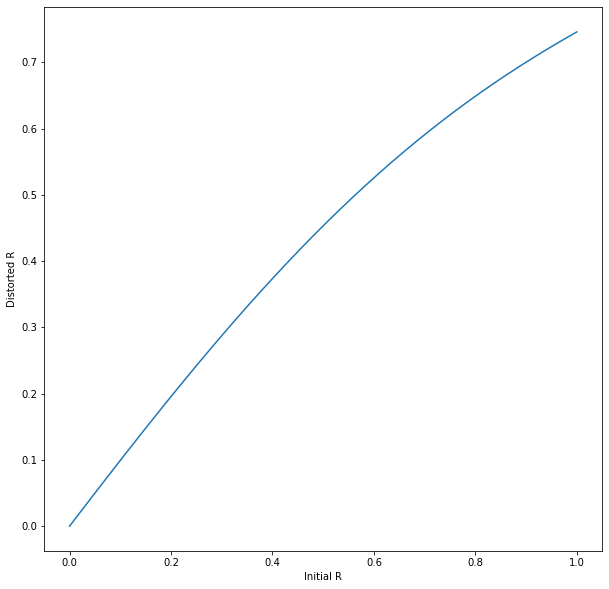

In [8]:
k1 = -0.0443637091577041
k2 = -0.35894053523797786
k3 = 0.14944647701164057

r = np.linspace(0,1,1000)
r_distorted = r*(1 + k1 * r + k2 * r**2 + k3 * r**3)


plt.xlabel('Initial R')
plt.ylabel('Distorted R')
plt.plot(r,r_distorted)

plt.show()

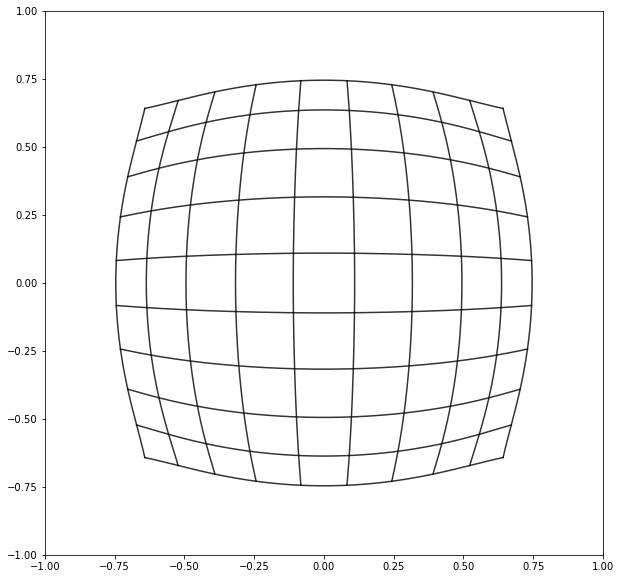

In [20]:
def distort_line(x,y):
    r = np.sqrt(x**2 + y**2)
    x_distorted = x*(1 + k1 * r + k2 * r**2 + k3 * r**3)
    y_distorted = y*(1 + k1 * r + k2 * r**2 + k3 * r**3)
    return(x_distorted,y_distorted)

for y in np.linspace(-1,1,10):
    x = np.linspace(-1,1,1000)
    x_distorted,y_distorted = distort_line(x,y)
    plt.plot(x_distorted,y_distorted,color='k',alpha=0.8)
    
for x in np.linspace(-1,1,10):
    y = np.linspace(-1,1,1000)
    x_distorted,y_distorted = distort_line(x,y)
    plt.plot(x_distorted,y_distorted,color='k',alpha=0.8)
    
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

## Finding an Inverse Function

In [11]:
def distort_point(distortion_params,r_distorted):
    undistorted = r_distorted*(1 + distortion_params[0] * r_distorted
                               + distortion_params[1] * r_distorted**2
                               + distortion_params[2] * r_distorted**3
                               + distortion_params[3] * r_distorted**4
                               + distortion_params[4] * r_distorted**5)
    return(undistorted)

def fun(distortion_params,r_distorted):
    #Compute residuals.
    undistorted = distort_point(distortion_params,r_distorted)
    return((undistorted - np.linspace(0,1,1000))).ravel()

In [4]:
x0 = np.zeros(5).ravel()
res = least_squares(fun, x0,  verbose=2, ftol=1e-12,loss='linear', args=([r_distorted]))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.6524e+00                                    3.02e+01    
       1              2         2.3534e-07      5.65e+00       9.81e-01       3.04e-08    
       2              3         2.3534e-07      1.81e-18       2.83e-06       1.11e-11    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 5.6524e+00, final cost 2.3534e-07, first-order optimality 1.11e-11.


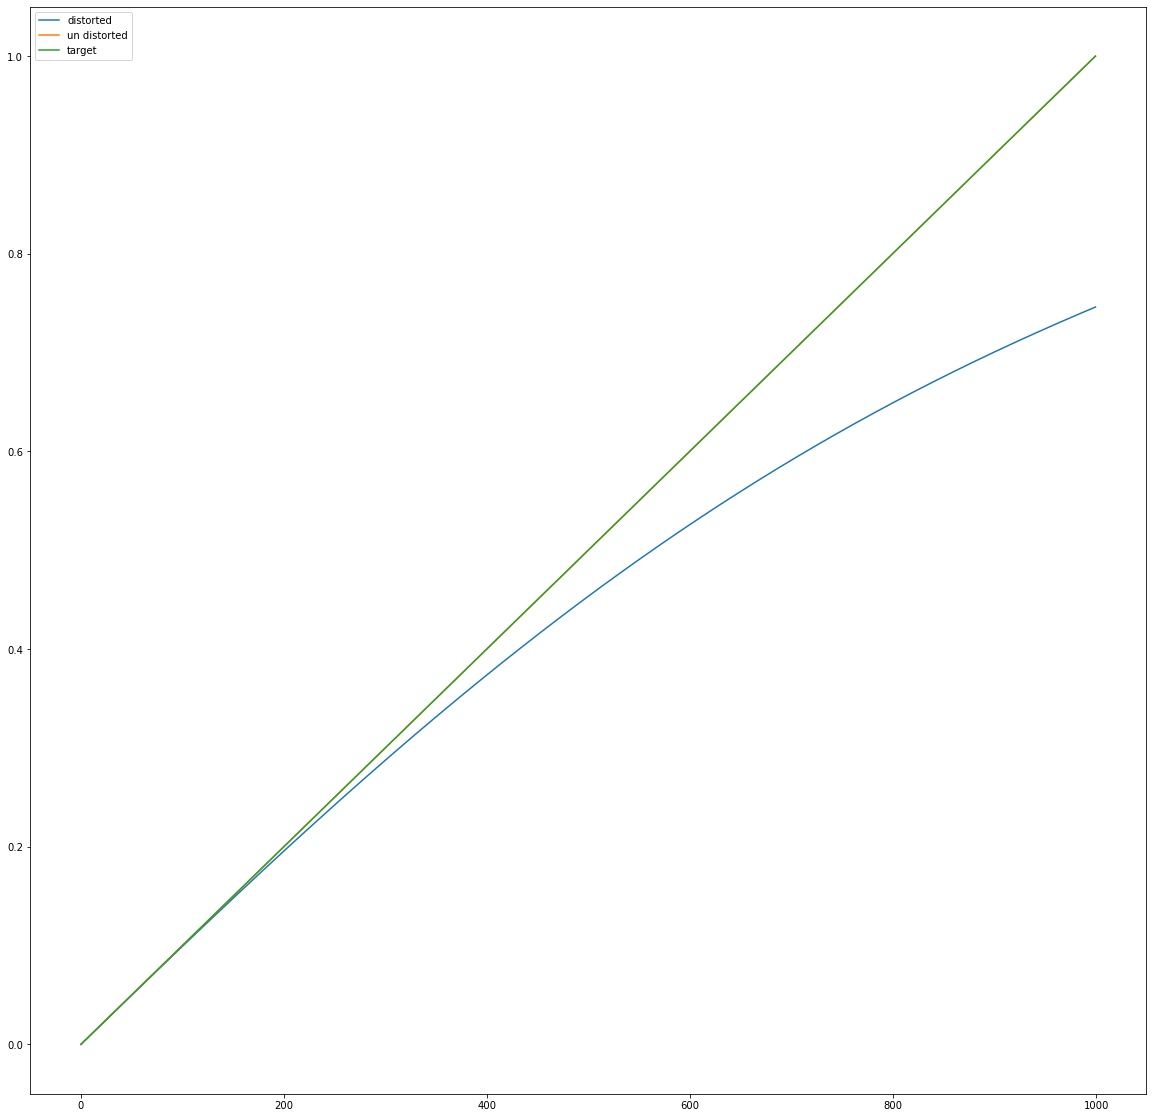

In [5]:
undistorted = distort_point(res.x,r_distorted)    
plt.plot(r_distorted,label='distorted')
plt.plot(undistorted,label='un distorted')
plt.plot(np.linspace(0,1,1000),label='target')
plt.legend()
plt.show()

In [6]:
print(res.x)

[ 0.04598032  0.32141486  0.2211217  -0.46139385  0.77101275]
